In [17]:
import pandas as pd
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
from collections import defaultdict

import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
import numpy as np
import matplotlib.pyplot as plt

get_ipython().run_line_magic("matplotlib", "inline")
font = {"weight": "normal", "size": 14, "family": "DejaVu Sans"}
plt.rc("text", usetex=True)
plt.rc("font", **font)


def rec_dd():
    return defaultdict(rec_dd)


# SINGLE CHAIN

In [18]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset"
)
hilary_full = "hilary-full-1-2-0"
hilary_cdr3 = "hilary-cdr3-1-2-0"


In [19]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [20]:
metric_dict_single=rec_dd()
for seed in [0, 1, 2]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    for freq in ["0.01","0.05","0.10","0.20","0.30"]:
        dataframe=pd.DataFrame()
        for model in ["simulations","partis","scoper",hilary_full,hilary_cdr3,"alignment_free"]:
            if model.startswith("alignment"):
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                            )
                        ).glob(f"*igh.tsv")
                    ][0],
                    sep=",",
                    index_col="sequence_id",
                )
            else :
                df = pd.read_csv(
                    [
                        each
                        for each in (benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-{freq}/{model}/single_chain/"
                        )).glob(f"*igh.tsv")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
            if model.startswith("hilary-full"):
                dataframe[model]=df["family"]
                dataframe["cdr3_length"] = df["cdr3_length"]

            if model.startswith("hilary-cdr3"):
                dataframe[model]=df["cdr3_based_family"]
            elif model.startswith("alignment"):
                dataframe[model] = df["CLONE"]
            else :
                dataframe[model]=df["clone_id"]

            sensitivity,precision=pairwise_evaluation(dataframe,model)
            varinfo = variation_of_info(dataframe,model)
            metric_dict_single[model]["precision"][freq][seed]=precision
            metric_dict_single[model]["sensitivity"][freq][seed]=sensitivity
            metric_dict_single[model]["variation_of_info"][freq][seed]=varinfo


/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_657264/1007109881.py:24: DtypeWarning: Columns (2,3,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.re

# PAIRED CHAIN

In [21]:
metric_dict_paired = rec_dd()
for seed in [0, 1, 2]:
    prec_list = []
    sens_list = []
    var_list = []
    for freq in ["0.01", "0.05", "0.10", "0.20", "0.30"]:
        dataframe = pd.DataFrame()
        for model in ["simulations", "partis", "scoper", hilary_full]:
            if model == "scoper":
                df = pd.read_csv(
                    benchmark_path
                    / Path(
                        f"seed-{seed}/scratch-mute-freq-{freq}/{model}/both_chains/partition.tsv"
                    ),
                    sep="\t",
                    index_col="sequence_id",
                )
            else:
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/both_chains/"
                            )
                        ).glob(f"*igh.tsv")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
            if model.startswith("hilary"):
                dataframe[model] = df["family"]
                dataframe["cdr3_length"] = df["cdr3_length"]
                dataframe[model + "_cdr3-based"] = df["cdr3_based_family"]
            else:
                dataframe[model] = df["clone_id"]

            sensitivity, precision = pairwise_evaluation(dataframe, model)
            varinfo = variation_of_info(dataframe, model)
            metric_dict_paired[model]["precision"][freq][seed] = precision
            metric_dict_paired[model]["sensitivity"][freq][seed] = sensitivity
            metric_dict_paired[model]["variation_of_info"][freq][seed] = varinfo
            if model.startswith("hilary"):
                model_cdr3 = model + "_cdr3-based"
                sensitivity, precision = pairwise_evaluation(dataframe, model_cdr3)
                varinfo = variation_of_info(dataframe, model_cdr3)
                metric_dict_paired[model_cdr3]["precision"][freq][seed] = precision
                metric_dict_paired[model_cdr3]["sensitivity"][freq][seed] = sensitivity
                metric_dict_paired[model_cdr3]["variation_of_info"][freq][seed] = varinfo


# PLOTS

scoper
hilary-full-1-2-0_cdr3-based
hilary-full-1-2-0
partis


/tmp/ipykernel_657264/4005032178.py:119: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


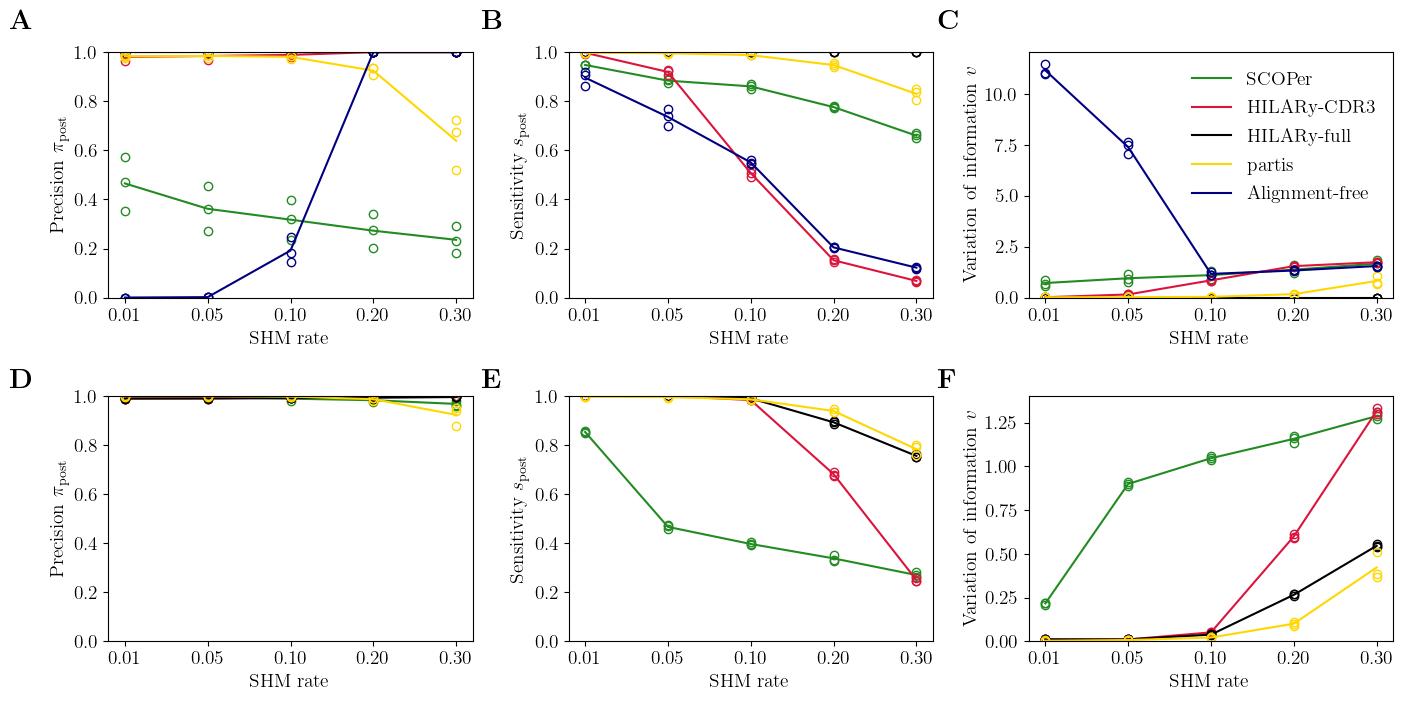

In [33]:
ls = [0.01,0.05,0.10,0.20,0.30]
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(231)
ax1.set_ylabel(r"Precision $\pi_{\rm post}$")
ax1.set_xlabel(r"SHM rate")
ax2 = fig.add_subplot(232)
ax2.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax2.set_xlabel(r"SHM rate")
ax3 = fig.add_subplot(233)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"SHM rate")

colors={"scoper":"forestgreen",hilary_cdr3:"crimson",hilary_full:"k","partis":"gold","alignment_free":"navy"}
axes=[ax1,ax2,ax3]

for model in colors:
    if model == hilary_full:
        label = "HILARy-full"
    elif model == hilary_cdr3:
        label = "HILARy-CDR3"
    elif model == "partis":
        label = "partis"
    elif model == "alignment_free":
        label = "Alignment-free"
    elif model == "scoper":
        label = "SCOPer"
    for i,metric in enumerate(metric_dict_single[model]):
        for freq in metric_dict_single[model][metric]:
            y=list(metric_dict_single[model][metric][freq].values())
            x=[freq]*len(y)
            axes[i].plot(
                x, y, "o", fillstyle="none", color=colors[model],
            )
        lengths=[]
        averages=[]
        for freq in metric_dict_single[model][metric]:
            lengths.append(freq)
            averages.append(np.mean(list(metric_dict_single[model][metric][freq].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )

ax3.legend(frameon=False)

"-------------------------------------------------------------------------------------"

ls = [0.01, 0.05, 0.10, 0.20, 0.30]
ax4 = fig.add_subplot(234)
ax4.set_ylabel(r"Precision $\pi_{\rm post}$")
ax4.set_xlabel(r"SHM rate")
ax5 = fig.add_subplot(235)
ax5.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax5.set_xlabel(r"SHM rate")
ax6 = fig.add_subplot(236)
ax6.set_ylabel(r"Variation of information $v$")
ax6.set_xlabel(r"SHM rate")

colors = {
    "scoper": "forestgreen",
    f"{hilary_full}_cdr3-based": "crimson",
    hilary_full: "k",
    "partis": "gold",
}
axes = [ax4, ax5, ax6]

for model in colors:
    if model == hilary_full:
        label = "HILARy-full"
    elif model == hilary_cdr3:
        label = "HILARy-CDR3"
    elif model == "partis":
        label = "partis"
    elif model =="alignment_free":
        label="Alignment-free"
    elif model=="scoper":
        label="SCOPer"
    print(model)
    for i, metric in enumerate(metric_dict_paired[model]):
        for freq in metric_dict_paired[model][metric]:
            y = list(metric_dict_paired[model][metric][freq].values())
            x = [freq] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for freq in metric_dict_paired[model][metric]:
            lengths.append(freq)
            averages.append(np.mean(list(metric_dict_paired[model][metric][freq].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )

ax1.set_ylim(bottom=0,top=1)
ax2.set_ylim(bottom=0, top=1)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0, top=1)
ax5.set_ylim(bottom=0, top=1)
ax6.set_ylim(bottom=0)


plt.tight_layout(pad=1.4)
plt.text(-12.5, 3.5, r"\bf{A}", rotation=0, wrap=True, fontsize=20)
plt.text(-6.8, 3.5, r"\bf{B}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.3, 3.5, r"\bf{C}", rotation=0, wrap=True, fontsize=20)
plt.text(-12.5, 1.45, r"\bf{D}", rotation=0, wrap=True, fontsize=20)
plt.text(-6.8, 1.45, r"\bf{E}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.3, 1.45, r"\bf{F}", rotation=0, wrap=True, fontsize=20)
plt.tight_layout()
fig.subplots_adjust(hspace=0.4)

plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_01_26/figures/si_figure9.pdf",
    bbox_inches="tight",
)
plt.show()
